In [1]:
from astropy.cosmology import Planck18
import astropy.units as u
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np

from scipy.integrate import trapz

import scipy.constants as scc
import astropy.constants as const

from pycbc import waveform as wf


##############################
plt.rcParams['text.usetex'] = True

fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,18,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize



/Users/lvanson/anaconda3/lib/python3.11/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [2]:
########################################################
# Made up BBH mass function
def dNdlnMdVdt_binaries(m):
    """
    Defining a mass distribution of merging BBHs
    I.e. number density of BBHs per unit logarithmic mass
    """
    # A peak at 10 Msun (representing the peak of the BBH mass distribution)
    g1 = 20*np.exp(-0.5*np.square((m-10)/2))

    # a peak at 35 Msun (unknown origin!)
    g2 = 5*np.exp(-0.5*np.square((m-35)/5))

    # a power law (something like the Salpeter IMF, but for BBHs)
    pl = 1*(m/20)**-2.5

    # peak at 60 Msun (representing the lower edge of the mass gap)
    g3 = 0.1*np.exp(-0.5*np.square((m-60)/5))
    
    # peak at 150 Msun (representing the upper edge of the mass gap)
    g4 = 1e-2*np.exp(-0.5*np.square((m-150)/20))

    # (m > 60) & (m < 115) adds in a PISN mass gap
    return np.where(((m > 60) & (m < 150)) | (m < 2.5), 0, g1 + g2 + pl + g3 + g4)


########################################################
# Made up BBH mass function
def dNdlnMdVdt_other(m):
    """
    Defining a mass distribution of merging BBHs
    From hierarchical mergers or something?
    I.e. number density of BBHs per unit logarithmic mass
    """
    # Some peak of non-binaries in the middle of the mass gap ~80
    g1 = 0.025*np.exp(-0.5*np.square((m-80)/30))
    
    return g1 


def dNdlnMdVdt(m):

    return dNdlnMdVdt_binaries(m) + dNdlnMdVdt_other(m)


In [3]:
########################################################
# SFR(z) Madau & Dickinson 2014 shape
def md_sfr(z, a=0.015, b=2.77, c=2.9, d=5.6):
    """
    SFR(z) in Msun/yr/Mpc^3 functional form from Madau & Dickinson 2014
    default Madau & Dickinson 2014: a=0.015, b=2.7, c=2.9,  d=5.6
    Madau & Fragos 2017: a=0.01, b=2.6, c=3.2,  d=6.2        
    """
    dm_dtdMpc = a * (1 + z)**b/( 1 + ( (1+z)/c )**d ) #*u.Msun *u.yr**-1 *u.Mpc**-3
    return dm_dtdMpc 

In [4]:
# Create a grid of masses and redshifts
mgrid = np.exp(np.linspace(np.log(1), np.log(300), 124))
# Create a redshift grid that is equally spaced in ln(1+z), so its actually dln(1+z)
zgrid = np.expm1(np.linspace(np.log1p(0), np.log1p(5), 100)) 

MS, ZS = np.meshgrid(mgrid, zgrid, indexing='ij')

# Calculate the merger rate density
dNdlnMdzdt_grid = dNdlnMdVdt(MS)*md_sfr(ZS)*Planck18.differential_comoving_volume(ZS).to(u.Gpc**3/u.sr).value*4*np.pi/(1+ZS)


# 2D grid of merger density

/var/folders/mc/hhcvbs7n2jq7d_hr2d6qvjhm0000gq/T/ipykernel_31211/2850364074.py:1: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(mgrid, zgrid, dNdlnMdzdt_grid.T, norm=colors.LogNorm())


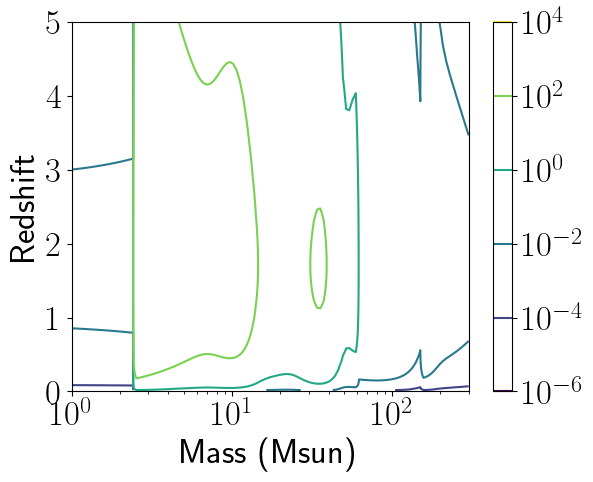

In [5]:
plt.contour(mgrid, zgrid, dNdlnMdzdt_grid.T, norm=colors.LogNorm())
plt.colorbar()
plt.xscale('log')
plt.xlabel('Mass (Msun)')
plt.xlabel('Mass (Msun)')
plt.ylabel('Redshift')
plt.show()  

# 1D merger rate at redshift ~0.2

0.19839816787754913


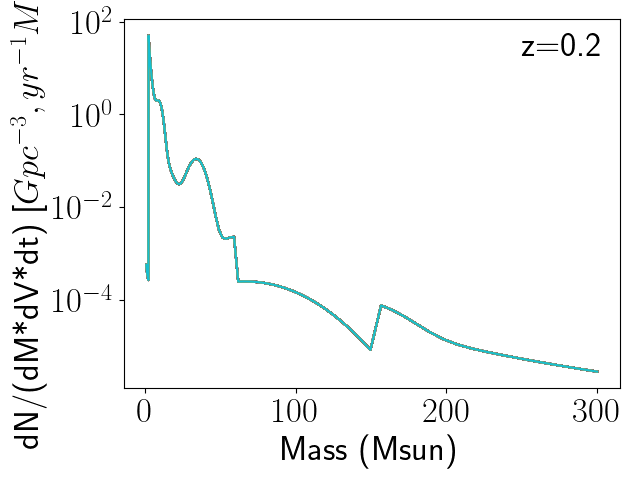

In [6]:
# Index where z=0.2
index_z02 = np.argmin(np.sqrt((zgrid - 0.2)**2) )
print( zgrid[index_z02] ) 

dNdlnMdzdt_grid[:,index_z02].shape

fig, ax = plt.subplots()

# Plot the merger rate as a function of mass
plt.plot(MS, (1/mgrid) * dNdlnMdzdt_grid[:,index_z02])

plt.xlabel('Mass (Msun)')
ax.text(0.8, 0.9, 'z=0.2', transform=ax.transAxes)
plt.ylabel('dN/(dM*dV*dt) [$Gpc^{-3}, yr^{-1} M^{-1}$] ')
# plt.xscale('log')
plt.yscale('log')
plt.show()

# Create a 2D filter for each detector based on the SNR
The following functions come from [the horizon_plot function](https://git.ligo.org/evan.hall/gw-horizon-plot)  by Evan Hall



In [7]:
def antennas(source_coords, det_coords, det_angles, freq=None):
    '''Return the plus and cross antenna patterns for GW sources incident on a detector network.
    Frequency dependence is not currently implemented.
    
    Arguments:
        source_coords (array): array of coordinates for GWs, each specified as [theta, phi, psi],
            where theta is the colatitude, phi is the longitude, and psi is the polarization angle
        det_coords (array): array of coordinates for detectors, each specified as [theta, phi]
        det_angles (array): array of angles describing detector arms, each specified as [rho, alpha],
            where rho is the angle of the X-arm wrt due east, and alpha is the detector opening angle
        return_times (boolean): if True, return the source times relative to geocenter. Defaults to True.
        
    Returns:
        det_plus (array): plus antenna pattern
        det_cross (array): cross antenna pattern
        source_times (array): source times relative to geocenter, in seconds.
    
    '''
    
    source_theta, source_phi, source_psi, _ = source_coords.T
    
    # Construct GW direction vectors
    source_n = np.array([
            np.sin(source_theta)*np.cos(source_phi),
            np.sin(source_theta)*np.sin(source_phi),
            np.cos(source_theta),
        ]).T
    source_ex = np.array([
            np.sin(source_phi) * np.cos(source_psi) - np.cos(source_theta) * np.cos(source_phi) * np.sin(source_psi),
            -np.cos(source_phi) * np.cos(source_psi) - np.cos(source_theta) * np.sin(source_phi) * np.sin(source_psi),
            np.sin(source_theta) * np.sin(source_psi),
        ]).T
    source_ey = np.array([
            -np.sin(source_phi) * np.sin(source_psi) - np.cos(source_theta) * np.cos(source_phi) * np.cos(source_psi),
            np.cos(source_phi) * np.sin(source_psi) - np.cos(source_theta) * np.sin(source_phi) * np.cos(source_psi),
            np.sin(source_theta) * np.cos(source_psi),
        ]).T
    
    # Construct detector direction vectors
    det_theta, det_phi = det_coords.T
    det_rho, det_alpha = det_angles.T
    
    det_n = np.array([
            np.sin(det_theta)*np.cos(det_phi),
            np.sin(det_theta)*np.sin(det_phi),
            np.cos(det_theta),
        ]).T
    det_ex = np.array([
            np.sin(det_phi) * np.cos(-det_rho) - np.cos(det_theta) * np.cos(det_phi) * np.sin(-det_rho),
            -np.cos(det_phi) * np.cos(-det_rho) - np.cos(det_theta) * np.sin(det_phi) * np.sin(-det_rho),
            np.sin(det_theta) * np.sin(-det_rho),
        ]).T
    det_ey = np.array([
            np.sin(det_phi) * np.cos(-det_rho-det_alpha) - np.cos(det_theta) * np.cos(det_phi) * np.sin(-det_rho-det_alpha),
            -np.cos(det_phi) * np.cos(-det_rho-det_alpha) - np.cos(det_theta) * np.sin(det_phi) * np.sin(-det_rho-det_alpha),
            np.sin(det_theta) * np.sin(-det_rho-det_alpha),
        ]).T
    
    # Construct source tensors
    source_plus = np.einsum('...a,...b', source_ex, source_ex) - np.einsum('...a,...b', source_ey, source_ey)
    source_cross = np.einsum('...a,...b', source_ex, source_ey) + np.einsum('...a,...b', source_ey, source_ex)

    # Construct detector freq resp
    if freq is None:
        Dx = 0.5*np.ones((source_n.shape[0], det_ex.shape[0]))
        Dy = 0.5*np.ones((source_n.shape[0], det_ex.shape[0]))
    else:
        LL = det_dict['det_lengths'][0]
        nx = np.einsum('ab,cb -> ac', source_n, det_ex)
        ny = np.einsum('ab,cb -> ac', source_n, det_ey)
        Dx = (scc.c / (8j * np.pi * freq * LL)
              * ((1 - np.exp(-2j*np.pi*freq*(1-nx)*LL/scc.c)) / (1 - nx)
              - np.exp(-4j*np.pi*freq*LL/scc.c) * (1 - np.exp(2j*np.pi*freq*(1+nx)*LL/scc.c)) / (1 + nx)))
        Dy = (scc.c / (8j * np.pi * freq * LL)
              * ((1 - np.exp(-2j*np.pi*freq*(1-ny)*LL/scc.c)) / (1 - ny)
              - np.exp(-4j*np.pi*freq*LL/scc.c) * (1 - np.exp(2j*np.pi*freq*(1+ny)*LL/scc.c)) / (1 + ny)))
    
    #Dx2 = np.einsum('a,bc,bd -> abcd', Dx, det_ex, det_ex)
    #Dy2 = np.einsum('a,bc,bd -> abcd', Dy, det_ey, det_ey)
    
    Dx2 = np.einsum('ab,bc,bd->abcd', Dx, det_ex, det_ex)
    Dy2 = np.einsum('ab,bc,bd->abcd', Dy, det_ey, det_ey)

    #Construct detector tensor
    #det_tensor = 0.5 * (np.einsum('...a,...b', det_ex, det_ex) * Dx - np.einsum('...a,...b', det_ey, det_ey)) * Dy
    det_tensor = Dx2 - Dy2
    
    # Construct detector antenna responses
    det_plus = np.einsum('abc, adbc -> ad', source_plus, det_tensor)
    det_cross = np.einsum('abc, adbc -> ad', source_cross, det_tensor)
    
    det_plus = np.einsum('abc, adbc -> ad', source_plus, det_tensor)
    det_cross = np.einsum('abc, adbc -> ad', source_cross, det_tensor)
    
    return det_plus, det_cross

In [8]:
def get_waveform(m1=30, m2=30, phic=0, distance=1e3):
    """
    Use pycbc to calculate the waveform
    """
    # Calculate the frequency of the innermost stable circular orbit (ISCO) for a binary system with masses m1 and m2
    fisco = const.c**3/(const.G*6**1.5*2*np.pi*(m1+m2)*const.M_sun)
    fisco = fisco.value

    # Calculate the frequency step df for the waveform
    df = 2**(np.max([np.floor(np.log(fisco/1024)/np.log(2)), -4]))

    # Generate the waveform using the get_fd_waveform function from the pycbc.waveform module
    mywf_p, mywf_c = wf.get_fd_waveform(
                        approximant='IMRPhenomD',  # The model used to generate the waveform
                        mass1=m1,  # The mass of the first binary component
                        mass2=m2,  # The mass of the second binary component
                        spin1z=0,  # The z-component of the spin of the first binary component
                        spin2z=0,  # The z-component of the spin of the second binary component
                        coa_phase=phic,  # The phase of the coalescence
                        distance=distance,  # The distance to the binary
                        delta_f = df,  # The frequency step
                        f_lower = 0.5,  # The lower frequency limit
                        f_final = 0,  # The final frequency
        )

    # Extract the frequencies at which the waveform is sampled
    ff = np.array(mywf_p.sample_frequencies)

    # Filter out the frequencies below 1 Hz and the corresponding waveform values
    mywfp = np.array(mywf_p.data)[ff>=1]
    ff = ff[ff>=1]

    # Return the filtered frequencies and waveform values
    return ff, mywfp


def lum_dist_astropy(zz_arr):
    """Luminosity distance from astropy """
    return Planck18.luminosity_distance(zz_arr).value

## Load the detector noise data

In [9]:
# Noise functions
f_ce_nu, strain_ce_nu = np.loadtxt('gw-horizon-plot/data/ce_wb.dat').T
f_ce, strain_ce = np.loadtxt('gw-horizon-plot/data/ce_wb_unfsr.dat').T
f_et, strain_et = np.loadtxt('gw-horizon-plot/data/et_d.dat').T
f_voy, strain_voy = np.loadtxt('gw-horizon-plot/data/voyager.dat').T
f_aligo, strain_aligo = np.loadtxt('gw-horizon-plot/data/aligo.dat').T

def ce_noise(ff):
    return np.interp(ff, f_ce, strain_ce, left=1e-19, right=np.Inf)

def ce_noise_nu(ff):
    return np.interp(ff, f_ce_nu, strain_ce_nu, left=1e-19, right=np.Inf)

def et_noise(ff):
    return np.interp(ff, f_et[f_et>3], strain_et[f_et>3], left=np.Inf, right=np.Inf)

def voy_noise(ff):
    return np.interp(ff, f_voy, strain_voy, left=1e-19, right=np.Inf)

def aligo_noise(ff):
    return np.interp(ff, f_aligo, strain_aligo, left=1e-19, right=np.Inf)

det_noises = [aligo_noise, voy_noise, et_noise, ce_noise]
det_noises_nu = [aligo_noise, voy_noise, et_noise, ce_noise_nu]

# Build detector dictionaries
aligo_dict = {'det_coords': np.array([[0, 0]]),
              'det_angles': np.array([[0, np.pi/2]]),
              'det_noises': [aligo_noise],
              'det_lengths': np.array([4e3]),
              'label': 'aLIGO',
             }

et_dict = {'det_coords': np.array([
                [0, 0],
                [0, 0],
                [0, 0],
            ]),
           'det_angles': np.array([
                [0, np.pi/3],
                [np.pi/3, np.pi/3],
                [2*np.pi/3, np.pi/3],
            ]),
           'det_noises': 3*[et_noise],
           'det_lengths': np.array(3*[10e3]),
           'label': 'ET',
          }


det_dict_list = [aligo_dict, et_dict]

for det_dict in det_dict_list:

    det_coords = det_dict['det_coords']
    det_angles = det_dict['det_angles']

    det_dict['det_plus_opt'], det_dict['det_cross_opt'] = antennas(np.array([[0, 0, 0, 0]]), det_coords, det_angles)
    det_dict['extinction_opt'] = det_dict['det_plus_opt']**2 + det_dict['det_cross_opt']**2
    
    det_dict['opt_snrs'] = np.zeros((len(mgrid), len(zgrid)))


Essentially we want to calculate the SNR ratio for every mass and redshift that we consider. The noise will come from the detector sentitivity curves. 
We can then define a detection to be anything that has an SNR above some limit, let's pick 

$$
\mathrm{SNR_{det lim}} = 8
$$


For an evolving and circular binary, (see also eq. 72 in [Tom Wagg's super helpful derivations](https://legwork.readthedocs.io/en/latest/notebooks/Derivations.html#Signal-to-Noise-Ratios-for-a-6-link-(3-arm)-LISA-(snr))) the SNR can be calculated as:


\begin{equation}
\mathrm{SNR} = 4 \int_{f_{2,1}}^{f_{2,f}} \frac{h^2_{c}}{S_n (f) } df
\end{equation}

where $h^2_{c}$ is the strain amplitude of a GW source (which we calculate with the pycbc waveform, that returns a strain per freq),
$S_n (f)$ is the effective noise power spectral density for the detector in question.

This is averaged over position, direction, and orientation/polarisation. 




In [10]:
########################################
# SNR function by Evan Hall
def snrfunc(zz, zz0, ff0, waveform0, source_extinctions, det_noises):
    """
    Calculate the SNR for a GW signal a given redshift `zz`. 
    The SNR is calculated by integrating the product of the weights and the square of the integrand over frequency. 
    The weights are calculated by taking the reciprocal of the square of the detector noise and multiplying by the source extinctions.
    The integrand is the waveform scaled by the ratio of the luminosity distances and the factor `(1+zz)**2`.
    """
    # Calculate the luminosity distance at the initial redshift zz0
    lum_dist0 = lum_dist_astropy(zz0)

    # Scale the frequency by 1/(1+zz) to account for the redshift
    ff = ff0/(1+zz)

    # Calculate the square of the detector noise at the redshifted frequency for each detector
    det_noises_sq_arr = np.array([np.square(det_noises[kk](ff)) for kk in range(len(det_noises))])

    # Calculate the weights for each detector by taking the reciprocal of the detector noise squared
    # and multiplying by the source extinctions
    weights = np.einsum('a,ab', source_extinctions, np.reciprocal(det_noises_sq_arr))

    # Calculate the integrand for the SNR integral. This is the waveform scaled by the ratio of the
    # luminosity distances and the factor (1+zz)**2
    intgnd = waveform0*lum_dist0/lum_dist_astropy(zz)*(1+zz)**2

    # Calculate the square of the SNR by integrating the product of the weights 
    # and the square of the integrand over frequency
    snrsq = 4 * np.trapz(weights*(np.square(np.real(intgnd))+np.square(np.imag(intgnd))), ff)

    # Return the square root of the maximum of snrsq and 0
    return np.sqrt(np.max([snrsq, 0]))
    #return np.sqrt(np.max(4 * np.trapz(weights*np.abs(waveform0*lum_dist0/lum_dist_astropy(zz)*(1+zz)**2)**2, ff), 0))



In [11]:
start_redshift = 0.001

###############################################
# !!! Warning, this will take a while to run !!!
# Loop over each detector dictionary in det_dict_list
for det_dict in det_dict_list:

    # Loop over each total mass in mgrid
    for mass_i, mass in enumerate(mgrid):
        # Generate a waveform for equal mass binary at the starting redshift
        ff, mywf = get_waveform(m1=mass, m2=mass, distance=lum_dist_astropy(start_redshift))

        # Loop over each redshift in zgrid
        for redshift_i, zz in enumerate(zgrid):
            # Calculate the signal-to-noise ratio (SNR) for the waveform at the redshift zz
            # and store it in the 'opt_snrs' array of the detector dictionary
            det_dict['opt_snrs'][mass_i, redshift_i] = snrfunc(zz, start_redshift, ff, mywf, det_dict['extinction_opt'][0], det_dict['det_noises'])


/var/folders/mc/hhcvbs7n2jq7d_hr2d6qvjhm0000gq/T/ipykernel_31211/3649666633.py:25: RuntimeWarning: divide by zero encountered in divide
  intgnd = waveform0*lum_dist0/lum_dist_astropy(zz)*(1+zz)**2
/var/folders/mc/hhcvbs7n2jq7d_hr2d6qvjhm0000gq/T/ipykernel_31211/3649666633.py:25: RuntimeWarning: invalid value encountered in divide
  intgnd = waveform0*lum_dist0/lum_dist_astropy(zz)*(1+zz)**2
/var/folders/mc/hhcvbs7n2jq7d_hr2d6qvjhm0000gq/T/ipykernel_31211/3649666633.py:25: RuntimeWarning: invalid value encountered in multiply
  intgnd = waveform0*lum_dist0/lum_dist_astropy(zz)*(1+zz)**2


# 1D rate of mergers over the whole Universe

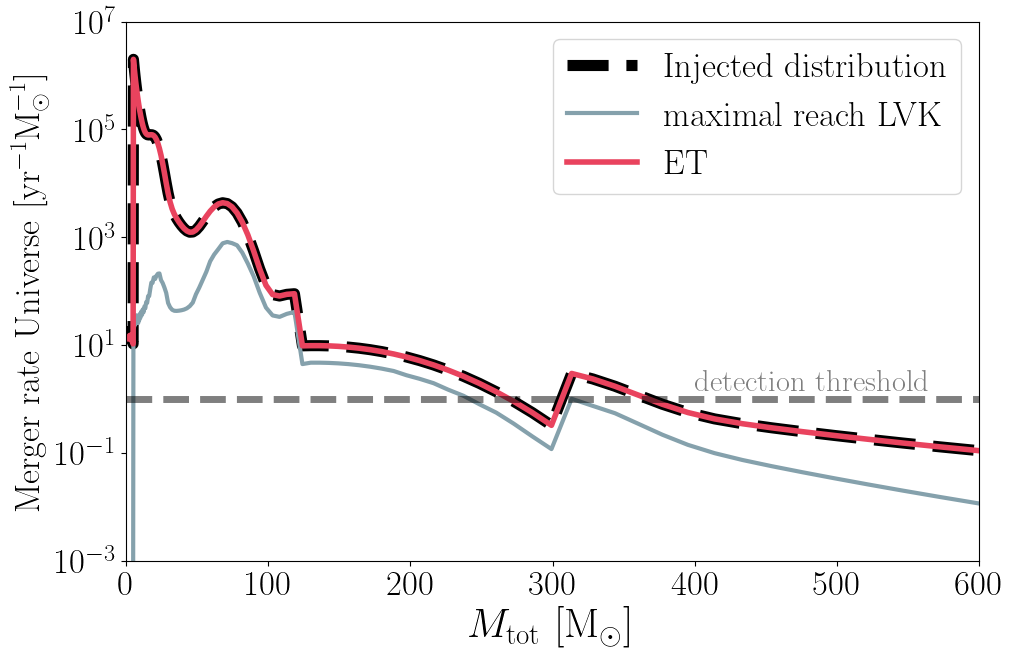

In [12]:
########################################
# I get very confused from logarithmic x-axes
from pydoc import cli


dNdMdzdt_grid = (1/mgrid[:, np.newaxis]) * dNdlnMdzdt_grid

# convert redshifts to volumnes and ensure all volumes are in Gpc^3
# volumes = Planck18.comoving_volume(zgrid).to(u.Gpc**3).value

# # split volumes into shells and duplicate last shell to keep same length
# shell_volumes = np.diff(volumes)
# shell_volumes = np.append(shell_volumes, shell_volumes[-1])


# This is dV/dz
shell_volumes = 4.0*np.pi*Planck18.differential_comoving_volume(zgrid).to(u.Gpc**3/u.sr).value

# Start Figure
fig, ax = plt.subplots(figsize=(11, 7) )

#############################
# The 'injected' merger rate 
# dNdlnMdt  = np.sum(dNdMdzdt_grid * shell_volumes , axis=1)
dNdlnMdt = np.trapz(dNdMdzdt_grid * shell_volumes, zgrid, axis = 1)
plt.plot(2* mgrid, dNdlnMdt, c = 'black', label = '$\mathrm{Injected \ distribution}$', lw = 8, ls = '--')

#############################
# The LVK observed merger rate (assuming a detection limit of SNR > 8)
LVK_SNR_filter = aligo_dict['opt_snrs'] > 8
dNdMdzdt_LVK  = (dNdMdzdt_grid  * LVK_SNR_filter)
# 'integrate' over redshift
dNdMdt_LVK = np.trapz(dNdMdzdt_LVK * shell_volumes, zgrid, axis = 1)
plt.plot(2* mgrid, dNdMdt_LVK, label = '$\mathrm{maximal \ reach \ LVK}$', c = '#85a1ac', lw = 3)

# #############################
# The ET observed merger rate (assuming a detection limit of SNR > 8)
ET_SNR_filter = et_dict['opt_snrs'] > 8
dNdMdzdt_ET  = (dNdMdzdt_grid  * ET_SNR_filter)
# 'integrate' over redshift
dNdMdt_ET = np.trapz(dNdMdzdt_ET * shell_volumes, zgrid, axis = 1)
plt.plot(2* mgrid, dNdMdt_ET, label = '$\mathrm{ET}$', c = '#e9435e', lw = 4)

ax.axhline(1, color = 'black', linestyle = '--', alpha = 0.5, lw = 5)
ax.text(400, 1.4, '$\mathrm{detection \ threshold}$', fontsize=22, color='black', alpha=0.5) #transform=ax.transAxes,

# Plot values
plt.xlabel('$M_{\mathrm{tot} }$ $\mathrm{[M_{\odot}]}$', fontsize = 30)
plt.ylabel('$\mathrm{Merger \ rate \ Universe}$ $\mathrm{[yr^{-1} M_{\odot}^{-1}]}$')
# plt.xscale('log')
plt.xlim(0,600)
plt.yscale('log')
plt.ylim(1e-3, 1e7)
plt.legend(fontsize = 25)
plt.savefig('Mass_dist_merger_rate_Universe.png', bbox_inches='tight')
plt.show()


# font = {'color':  'k','weight': 'bold', 'size': 17,'stretch': 'condensed'}


# Re-do with Will's SNR code

In [ ]:
import astropy.cosmology as cosmo
import astropy.units as u
import lal
import lalsimulation as ls
from pylab import *

def draw_thetas(N):
    """Draw `N` random angular factors for the SNR.

    Theta is as defined in [Finn & Chernoff
    (1993)](https://ui.adsabs.harvard.edu/#abs/1993PhRvD..47.2198F/abstract).
    """

    cos_thetas = np.random.uniform(low=-1, high=1, size=N)
    cos_incs = np.random.uniform(low=-1, high=1, size=N)
    phis = np.random.uniform(low=0, high=2*np.pi, size=N)
    zetas = np.random.uniform(low=0, high=2*np.pi, size=N)
    
    Fps = 0.5*cos(2*zetas)*(1 + square(cos_thetas))*cos(2*phis) - sin(2*zetas)*cos_thetas*sin(2*phis)
    Fxs = 0.5*sin(2*zetas)*(1 + square(cos_thetas))*cos(2*phis) + cos(2*zetas)*cos_thetas*sin(2*phis)
    
    return np.sqrt(0.25*square(Fps)*square(1 + square(cos_incs)) + square(Fxs)*square(cos_incs))

thetas = draw_thetas(10000)

def next_pow_two(x):
    """Return the next (integer) power of two above `x`.

    """
    
    x2 = 1
    while x2 < x:
        x2 = x2 << 1
    return x2

def optimal_snr(m1_intrinsic, m2_intrinsic, chi1, chi2, z, psd_fn=ls.SimNoisePSDaLIGOEarlyHighSensitivityP1200087 ,
                fmin = 19.0, fref = 40.0, psdstart = 20.0):
    # Basic setup: min frequency for w.f., PSD start freq, etc.
    """Return the optimal SNR of a signal.

    :param m1_intrinsic: The source-frame mass 1.

    :param m2_intrinsic: The source-frame mass 2.

    :param chi1: The aligned spin component for mass 1.

    :param chi2: The aligned spin component for mass 2.

    :param z: The redshift.

    :param psd_fn: A function that returns the detector PSD at a given
      frequency (default is early aLIGO high sensitivity, defined in
      [P1200087](https://dcc.ligo.org/LIGO-P1200087/public).

    :return: The SNR of a face-on, overhead source.

    """
    
    # Get dL, Gpc
    dL = cosmo.Planck15.luminosity_distance(z).to(u.Gpc).value
    
    # This is a conservative estimate of the chirp time + MR time (2 seconds)
    tmax = ls.SimInspiralChirpTimeBound(fmin, m1_intrinsic*(1+z)*lal.MSUN_SI, m2_intrinsic*(1+z)*lal.MSUN_SI, abs(chi1), abs(chi2)) + 2
    
    df = 1.0/next_pow_two(tmax)
    fmax = 2048.0 # Hz --- based on max freq of 5-5 inspiral

    # Generate the waveform, redshifted as we would see it in the detector, but with zero angles (i.e. phase = 0, inclination = 0)
    hplus_fd, hcross_fd= ls.SimInspiralChooseFDWaveform((1+z)*m1_intrinsic*lal.MSUN_SI, (1+z)*m2_intrinsic*lal.MSUN_SI, 0.0, 0.0, chi1, 0.0, 0.0, chi2, dL*1e9*lal.PC_SI, 0.0, 0.0, 0.0, 0.0, 0.0, df, fmin, fmax, fref, None, ls.IMRPhenomPv2)
    ff, mywf = get_waveform(m1=mass, m2=mass, distance=lum_dist_astropy(start_redshift))

    Nf = int(round(fmax/df)) + 1
    fs = linspace(0, fmax, Nf)
    sel = fs > psdstart
    
    # PSD
    sffs = lal.CreateREAL8FrequencySeries("psds", 0, 0.0, df, lal.DimensionlessUnit, fs.shape[0])
    print('sffs',sffs)
    psd_fn(sffs, psdstart)

    return ls.MeasureSNRFD(hplus_fd, sffs, psdstart, -1.0)


## This function from Will, will return the fraction of sources above a given threshold,(calculates "dV" ?)
# But I want to add my own rate in there, and then integrate over redshift to get the sensitive time-volume
def vt_from_mass_spins(m1, m2, chi1, chi2, thresh, analysis_time, calfactor=1.0, psd_fn=ls.SimNoisePSDaLIGOEarlyHighSensitivityP1200087,
                       zmin = 0.001, zmax = 1.0):
    """Returns the sensitive time-volume for a given system.

    :param m1: Source-frame mass 1.

    :param m2: Source-frame mass 2.

    :param chi1: Aligned spin component for mass 1.

    :param chi2: Aligned spin component for mass 2.

    :param analysis_time: The total detector-frame searched time.

    :param calfactor: Fudge factor applied multiplicatively to the final result.

    :param psd_fn: Function giving the assumed single-detector PSD
      (see :func:`optimal_snr`).

    :return: The sensitive time-volume in comoving Gpc^3-yr (assuming
      analysis_time is given in years).

    """
    def integrand(z):
        if z == 0.0:
            return 0.0
        else:
            return 4*np.pi*cosmo.Planck15.differential_comoving_volume(z).to(u.Gpc**3 / u.sr).value/(1+z)*fraction_above_threshold(m1, m2, chi1, chi2, z, thresh)        
        
    assert fraction_above_threshold(m1, m2, chi1, chi2, zmax, thresh) == 0.0
    assert fraction_above_threshold(m1, m2, chi1, chi2, zmin, thresh) > 0.0

    while zmax - zmin > 1e-3:
        zhalf = 0.5*(zmax+zmin)
        fhalf = fraction_above_threshold(m1, m2, chi1, chi2, zhalf, thresh)
        
        if fhalf > 0.0:
            zmin=zhalf
        else:
            zmax=zhalf
    
    zs = linspace(0.0, zmax, 20)
    ys = array([integrand(z) for z in zs])

    return calfactor*analysis_time*trapz(ys, zs)

## (re) Define dicts to store data in

In [ ]:
# Create a grid of masses and redshifts
mgrid = np.exp(np.linspace(np.log(1), np.log(300), 124))
# Create a redshift grid that is equally spaced in ln(1+z), so its actually dln(1+z)
zgrid = np.expm1(np.linspace(np.log1p(0), np.log1p(5), 100)) 

# Noise functions
f_ce_nu, strain_ce_nu = np.loadtxt('gw-horizon-plot/data/ce_wb.dat').T
f_ce, strain_ce = np.loadtxt('gw-horizon-plot/data/ce_wb_unfsr.dat').T
f_et, strain_et = np.loadtxt('gw-horizon-plot/data/et_d.dat').T
f_voy, strain_voy = np.loadtxt('gw-horizon-plot/data/voyager.dat').T
f_aligo, strain_aligo = np.loadtxt('gw-horizon-plot/data/aligo.dat').T

def ce_noise(ff):
    return np.interp(ff, f_ce, strain_ce, left=1e-19, right=np.Inf)

def ce_noise_nu(ff):
    return np.interp(ff, f_ce_nu, strain_ce_nu, left=1e-19, right=np.Inf)

def et_noise(ff):
    return np.interp(ff, f_et[f_et>3], strain_et[f_et>3], left=np.Inf, right=np.Inf)

def voy_noise(ff):
    return np.interp(ff, f_voy, strain_voy, left=1e-19, right=np.Inf)

def aligo_noise(ff):
    return np.interp(ff, f_aligo, strain_aligo, left=1e-19, right=np.Inf)

det_noises = [aligo_noise, voy_noise, et_noise, ce_noise]
det_noises_nu = [aligo_noise, voy_noise, et_noise, ce_noise_nu]

# Build detector dictionaries
aligo_dict = {'det_coords': np.array([[0, 0]]),
              'det_angles': np.array([[0, np.pi/2]]),
              'det_noises': [aligo_noise],
              'det_lengths': np.array([4e3]),
              'label': 'aLIGO',
             }

et_dict = {'det_coords': np.array([
                [0, 0],
                [0, 0],
                [0, 0],
            ]),
           'det_angles': np.array([
                [0, np.pi/3],
                [np.pi/3, np.pi/3],
                [2*np.pi/3, np.pi/3],
            ]),
           'det_noises': 3*[et_noise],
           'det_lengths': np.array(3*[10e3]),
           'label': 'ET',
          }


det_dict_list = [aligo_dict, et_dict]

for det_dict in det_dict_list:

    det_coords = det_dict['det_coords']
    det_angles = det_dict['det_angles']

    det_dict['det_plus_opt'], det_dict['det_cross_opt'] = antennas(np.array([[0, 0, 0, 0]]), det_coords, det_angles)
    det_dict['extinction_opt'] = det_dict['det_plus_opt']**2 + det_dict['det_cross_opt']**2
    
    det_dict['opt_snrs'] = np.zeros((len(mgrid), len(zgrid)))


In [ ]:
print(zgrid)

[0.         0.01826335 0.03686025 0.0557968  0.07507919 0.09471374
 0.11470688 0.13506517 0.15579526 0.17690396 0.19839817 0.22028494
 0.24257143 0.26526495 0.28837293 0.31190294 0.33586268 0.36026001
 0.38510292 0.41039954 0.43615817 0.46238723 0.48909532 0.5162912
 0.54398376 0.57218208 0.60089539 0.63013311 0.6599048  0.69022023
 0.72108932 0.75252218 0.78452911 0.81712059 0.85030731 0.88410012
 0.91851011 0.95354853 0.98922688 1.02555683 1.06255029 1.10021937
 1.13857641 1.17763399 1.21740489 1.25790213 1.299139   1.34112898
 1.38388584 1.42742359 1.47175648 1.51689904 1.56286606 1.60967258
 1.65733395 1.70586578 1.75528396 1.80560468 1.85684443 1.90901998
 1.96214844 2.0162472  2.07133399 2.12742684 2.18454414 2.24270459
 2.30192725 2.36223151 2.42363713 2.48616422 2.54983327 2.61466512
 2.68068102 2.7479026  2.81635186 2.88605124 2.95702357 3.02929208
 3.10288046 3.17781281 3.25411368 3.33180806 3.4109214  3.49147961
 3.57350908 3.65703669 3.74208979 3.82869625 3.91688443 4.00668

In [ ]:
start_redshift = 0.001


###############################################
# !!! Warning, this will take a while to run !!!
# Loop over each detector dictionary in det_dict_list
for det_dict in det_dict_list:

    # Loop over each total mass in mgrid
    for mass_i, mass in enumerate(mgrid):
        # Generate a waveform for equal mass binary at the starting redshift
        # ff, mywf = get_waveform(m1=mass, m2=mass, distance=lum_dist_astropy(start_redshift))

        # Loop over each redshift in zgrid
        for redshift_i, zz in enumerate(zgrid[1:]):
            # Calculate the signal-to-noise ratio (SNR) for the waveform at the redshift zz
            # and store it in the 'opt_snrs' array of the detector dictionary
            det_dict['opt_snrs'][mass_i, redshift_i] = optimal_snr(mass/(1+zz), mass/(1+zz), 0, 0, zz, psd_fn=ls.SimNoisePSDaLIGOEarlyHighSensitivityP1200087)
            
            # snrfunc(zz, start_redshift, ff, mywf, det_dict['extinction_opt'][0], det_dict['det_noises'])


sffs <Swig Object of type 'tagREAL8FrequencySeries *' at 0x148931fb0>
sffs <Swig Object of type 'tagREAL8FrequencySeries *' at 0x14880a0b0>
sffs <Swig Object of type 'tagREAL8FrequencySeries *' at 0x14a235df0>
sffs <Swig Object of type 'tagREAL8FrequencySeries *' at 0x14889f7f0>
sffs <Swig Object of type 'tagREAL8FrequencySeries *' at 0x14a2374b0>
sffs <Swig Object of type 'tagREAL8FrequencySeries *' at 0x1488030b0>
sffs <Swig Object of type 'tagREAL8FrequencySeries *' at 0x14887b970>
sffs <Swig Object of type 'tagREAL8FrequencySeries *' at 0x14889f4b0>
sffs <Swig Object of type 'tagREAL8FrequencySeries *' at 0x1488bd2f0>
sffs <Swig Object of type 'tagREAL8FrequencySeries *' at 0x13ffc5830>
sffs <Swig Object of type 'tagREAL8FrequencySeries *' at 0x14a2640b0>
sffs <Swig Object of type 'tagREAL8FrequencySeries *' at 0x1489aceb0>
sffs <Swig Object of type 'tagREAL8FrequencySeries *' at 0x14a229b70>
sffs <Swig Object of type 'tagREAL8FrequencySeries *' at 0x148931fb0>
sffs <Swig Object of

KeyboardInterrupt: 

In [ ]:
########################################
# I get very confused from logarithmic x-axes
dNdMdzdt_grid = (1/mgrid[:, np.newaxis]) * dNdlnMdzdt_grid

# convert redshifts to volumnes and ensure all volumes are in Gpc^3
# volumes = Planck18.comoving_volume(zgrid).to(u.Gpc**3).value

# # split volumes into shells and duplicate last shell to keep same length
# shell_volumes = np.diff(volumes)
# shell_volumes = np.append(shell_volumes, shell_volumes[-1])


# This is dV/dz
shell_volumes = 4.0*np.pi*Planck18.differential_comoving_volume(zgrid).to(u.Gpc**3/u.sr).value

# Start Figure
fig, ax = plt.subplots(figsize=(10, 8) )

#############################
# The 'injected' merger rate 
# dNdlnMdt  = np.sum(dNdMdzdt_grid * shell_volumes , axis=1)
dNdlnMdt = np.trapz(dNdMdzdt_grid * shell_volumes, zgrid, axis = 1)
plt.plot(2* mgrid, dNdlnMdt, c = 'black', label = 'Injected', lw = 3, ls = '--')

#############################
# The LVK observed merger rate (assuming a detection limit of SNR > 8)
LVK_SNR_filter = aligo_dict['opt_snrs'] > 8
dNdMdzdt_LVK  = (dNdMdzdt_grid  * LVK_SNR_filter)
# 'integrate' over redshift
dNdMdt_LVK = np.trapz(dNdMdzdt_LVK * shell_volumes, zgrid, axis = 1)
plt.plot(2* mgrid, dNdMdt_LVK, label = 'LVK', c = 'blue')

# #############################
# The ET observed merger rate (assuming a detection limit of SNR > 8)
ET_SNR_filter = et_dict['opt_snrs'] > 8
dNdMdzdt_ET  = (dNdMdzdt_grid  * ET_SNR_filter)
# 'integrate' over redshift
dNdMdt_ET = np.trapz(dNdMdzdt_ET * shell_volumes, zgrid, axis = 1)
plt.plot(2* mgrid, dNdMdt_ET, label = 'ET', c = 'red')

ax.axhline(1, color = 'black', linestyle = '--', alpha = 0.5)

# Plot values
plt.xlabel('$M_{\mathrm{tot} }$  [$M_{\odot}$]')
plt.ylabel('Universe rate $dN/(dM dt)$ [$yr^{-1} M_{\odot}^{-1}$]')
# plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-3, 1e7)
plt.legend()
plt.show()


# font = {'color':  'k','weight': 'bold', 'size': 17,'stretch': 'condensed'}


In [ ]:
print( optimal_snr(150, 150, 0, 0, 2, psd_fn=ls.SimNoisePSDaLIGOEarlyHighSensitivityP1200087) )
print( optimal_snr(150, 150, 0, 0, 2, psd_fn=ls.XLALSimNoisePSDEinsteinTelescopeP1600143) ) # P1600143 is doc number in DCC.ligo.org



sffs <Swig Object of type 'tagREAL8FrequencySeries *' at 0x13f6c4ef0>
0.6178755833003222


AttributeError: module 'lalsimulation' has no attribute 'XLALSimNoisePSDEinsteinTelescopeP1600143'